## Name: Sai Sriharsha Griddaluru
## CUID: C15358926

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as utils
import matplotlib.animation as animation
from IPython.display import HTML
import time
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn.functional as F
from scipy import linalg

In [2]:
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:',device)
LEARNING_RATE = 5e-5
BATCH_SIZE = 32
IMAGE_SIZE = 64
CHANNELS_IMG = 3  
NOISE_DIM = 100
NUM_EPOCHS = 40
FEATURES_DISC = 64 
FEATURES_GEN = 64 
criticItr = 5
lambda_GP = 10

Device: cuda


In [3]:
dataset = datasets.CIFAR10(root="./dataset/CIFAR10data", download=True,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2)

Files already downloaded and verified


In [4]:
import os
if not os.path.exists('results'):
   os.makedirs('results')

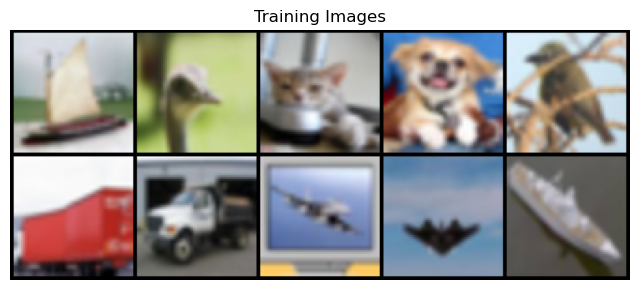

In [5]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:10],nrow=5, padding=2, normalize=True).cpu(),(1,2,0)))
plt.savefig('Results/WGANGP_RealImg.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

In [6]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()

        # Discriminator network structure
        self.disc = nn.Sequential(
            ## :: Input layer: Conv2d for initial feature extraction ::
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),  ## :: LeakyReLU activation ::

            ## :: Dnet blocks for feature extraction ::
            self.Dnet(features_d, features_d * 2, 4, 2, 1),  # 128x64x64 -> 128x32x32
            self.Dnet(features_d * 2, features_d * 4, 4, 2, 1),  # 128x32x32 -> 256x16x16
            self.Dnet(features_d * 4, features_d * 8, 4, 2, 1),  # 256x16x16 -> 512x8x8

            ## :: Final convolution to output single prediction (real/fake) ::
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),  # Output: 1x1x1
        )

    def Dnet(self, in_channels, out_channels, kernel_size, stride, padding):
        ## :: Create a sequential block for each layer of the discriminator ::
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),  ## :: Instance normalization ::
            nn.LeakyReLU(0.2),  ## :: LeakyReLU activation ::
        )

    def forward(self, x):
        ## :: Forward pass through the discriminator network ::
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()

        # Generator network structure
        self.net = nn.Sequential(
            ## :: Initial Gnet block: From noise to initial image features ::
            self.Gnet(channels_noise, features_g*8, 4, 1, 0),  # 512 x 4 x 4
            
            ## :: Additional Gnet blocks: Upsampling with feature expansion ::
            self.Gnet(features_g*8, features_g*4, 4, 2, 1),  # 256 x 8 x 8
            self.Gnet(features_g*4, features_g*2, 4, 2, 1),  # 128 x 16 x 16
            self.Gnet(features_g*2, features_g, 4, 2, 1),    # 64 x 32 x 32

            ## :: Final transposed convolution: Upscale to desired output size ::
            nn.ConvTranspose2d(features_g, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  ## :: Tanh activation to scale output between [-1, 1] ::
        )

    def Gnet(self, in_channels, out_channels, kernel_size, stride, padding):
        ## :: Create a sequential block for each layer of the generator ::
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels, momentum=0.9),  ## :: Batch normalization ::
            nn.ReLU(),  ## :: ReLU activation ::
        )

    def forward(self, x):
        ## :: Forward pass through the generator network ::
        return self.net(x)

In [7]:
def initialize_weights(model):
    ## :: Initialize weights for specific layers in the model ::
    for m in model.modules():
        ## :: Apply normal distribution to Conv2d, ConvTranspose2d, and BatchNorm2d layers ::
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)  ## :: Normal initialization with mean=0 and std=0.02 ::

def GP(critic, real, fake):
    ## :: Compute Gradient Penalty for Wasserstein GANs ::
    
    BATCH_SIZE, C, H, W = real.shape  ## :: Get batch dimensions of real images ::
    
    ## :: Random interpolation between real and fake images ::
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)
    
    ## :: Compute critic score for interpolated images ::
    mixed_scores = critic(interpolated_images)
    
    ## :: Calculate gradients with respect to interpolated images ::
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    
    ## :: Flatten the gradient tensor for norm calculation ::
    gradient = gradient.view(gradient.shape[0], -1)
    
    ## :: Compute L2 norm of the gradient ::
    gradient_norm = gradient.norm(2, dim=1)
    
    ## :: Compute gradient penalty term ::
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    
    return gradient_penalty  ## :: Return the computed gradient penalty ::


In [8]:
import os

## :: Create directory to store models if it doesn't exist ::
if not os.path.exists('models'):
    os.makedirs('models')

## :: Save model function for both Generator and Discriminator ::
def save_model(model):
    if model == 'gen':  ## :: Check if saving Generator model ::
        print("=> Saving model Generator!!")
        torch.save(model, "models/CIFAR_wganGP_GENERATOR.pth.tar")
    elif model == 'disc':  ## :: Check if saving Discriminator model ::
        print("=> Saving model Discriminator!!")
        torch.save(model, "models/CIFAR_wganGP_DIS.pth.tar")

## :: Load model function for both Generator and Discriminator ::
def load_model(gen, disc):
    print("=> Loading Models!!")
    ## :: Load pre-trained models from disk ::
    gen = torch.load("models/CIFAR_wganGP_GENERATOR.pth.tar")
    disc = torch.load("models/CIFAR_wganGP_DIS.pth.tar")
    
    return gen, disc  ## :: Return the loaded models ::

## :: Initialize Generator and Discriminator models ::
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)

## :: Apply weight initialization for both models ::
initialize_weights(gen)
initialize_weights(disc)

## :: Set optimizers for both Generator and Discriminator using RMSprop optimizer ::
optimGenerator = optim.RMSprop(gen.parameters(), lr=LEARNING_RATE)
optimDiscriminator = optim.RMSprop(disc.parameters(), lr=LEARNING_RATE)

## :: Initialize fixed noise for visualization during training ::
fixed_noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)

## :: Set the initial step and train mode for both models ::
step = 0
gen.train(), disc.train()  ## :: Set both models in training mode ::

(Generator(
   (net): Sequential(
     (0): Sequential(
       (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (1): Sequential(
       (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (2): Sequential(
       (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (3): Sequential(
       (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (4): ConvTr

In [9]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""
    
    ## :: Constants defining block indices by dimension ::
    DEFAULT_BLOCK_INDEX = 3
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling features
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        """Initialize the InceptionV3 model with selected output blocks."""
        super(InceptionV3, self).__init__()

        ## :: Store initialization parameters ::
        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        ## :: List to store sequential blocks ::
        self.blocks = nn.ModuleList()

        ## :: Load pretrained InceptionV3 model ::
        inception = models.inception_v3(pretrained=True)

        ## :: Block 0: input to maxpool1 ::
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        ## :: Block 1: maxpool1 to maxpool2 ::
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        ## :: Block 2: maxpool2 to aux classifier ::
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        ## :: Block 3: aux classifier to final avgpool ::
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        ## :: Set requires_grad for all parameters ::
        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Forward pass through selected blocks."""
        outp = []
        x = inp

        ## :: Resize input if required ::
        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        ## :: Normalize input if required ::
        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        ## :: Process input through each block ::
        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
## :: Define block index for output size 2048 ::
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]

## :: Initialize InceptionV3 model with selected block ::
model = InceptionV3([block_idx])
model = model.cuda()


def calculate_activation_statistics(images, model, batch_size=128, dims=2048, cuda=False):
    """Calculate activation statistics (mean and covariance) for a batch of images."""
    model.eval()
    
    ## :: Initialize empty array to store activations ::
    act = np.empty((len(images), dims))
    
    ## :: Move images to GPU if required ::
    batch = images.cuda() if cuda else images
    
    ## :: Forward pass through model and get activations ::
    pred = model(batch)[0]
    
    ## :: Ensure output is of shape (batch_size, dims) by averaging over spatial dimensions ::
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    ## :: Reshape and store activations ::
    act = pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    ## :: Calculate mean and covariance of activations ::
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    
    return mu, sigma


def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Calculate the Frechet Inception Distance (FID) between two distributions."""
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    ## :: Ensure mean and covariance dimensions are the same ::
    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    ## :: Calculate difference between means ::
    diff = mu1 - mu2

    ## :: Compute square root of covariance product ::
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    
    ## :: Handle numerical stability if covariance matrix is singular ::
    if not np.isfinite(covmean).all():
        msg = ('FID calculation produces singular product; '
               'adding %s to diagonal of covariance estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    ## :: Ensure covariance is real-valued ::
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    ## :: Calculate trace of covariance mean ::
    tr_covmean = np.trace(covmean)

    ## :: Return Frechet Inception Distance (FID) ::
    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)


def calculate_fretchet(images_real, images_fake, model):
    """Calculate Frechet Inception Distance (FID) between real and fake images."""
    ## :: Calculate activation statistics for real and fake images ::
    mu_1, std_1 = calculate_activation_statistics(images_real, model, cuda=True)
    mu_2, std_2 = calculate_activation_statistics(images_fake, model, cuda=True)

    ## :: Compute and return FID value ::
    fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
    return fid_value


/home/sgridda/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sgridda/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
#training block
GenLoss = []
DiscLoss = []
DiscLossP = []
img_list = []
iters = 0
FID_list = []

print("training...")
# start timing
time_start = time.time()
#NUM_EPOCHS
for epoch in range(NUM_EPOCHS):
    epoch = epoch+1
    
    for batch_idx, data in enumerate(dataloader,0):
        #training with real batch
        real = data[0].to(device)
        batch = real.shape[0]
        # print(batch == BATCH_SIZE)

        # Train Critic(Discriminator): max E[critic(real)] - E[critic(fake)]
        for i in range (criticItr):
            noise = torch.randn(batch, NOISE_DIM, 1, 1).to(device)
            fake = gen(noise) #genrator img data
            critic_real = disc(real).reshape(-1)
            critic_fake = disc(fake).reshape(-1)
            gp = GP(disc, real,fake)
            loss_critic = (-(torch.mean(critic_real) - torch.mean(critic_fake))+ (lambda_GP*gp))
            disc.zero_grad()
            loss_critic.backward(retain_graph=True)
            optimDiscriminator.step()

#           # clip critic weights between -0.01, 0.01
#             for param in disc.parameters():
#                 param.data.clamp_(-weight_clip, weight_clip)


        ### Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        output = disc(fake).reshape(-1)
        loss_gen = -torch.mean(output) 
        gen.zero_grad()
        loss_gen.backward()
        optimGenerator.step()

        # Print losses occasionally and print to tensorboard
#         if batch_idx % 100  == 0:
#                print(f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
#                   Loss Discriminator: {loss_critic:.3f}, loss Generator: {loss_gen:.3f}",end = '\r', flush=True
#                 )
        #saving the losses for every 100 batch
        GenLoss.append(loss_gen.detach().cpu())
        DiscLoss.append(loss_critic.detach().cpu())

        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == NUM_EPOCHS) and (batch_idx == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
    #Cal. FID
    fretchet_dist=calculate_fretchet(real,fake,model)
    FID_list.append(fretchet_dist)
    print(f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                  Loss Discriminator: {loss_critic:.3f}, loss Generator: {loss_gen:.3f}, FID Score: {fretchet_dist:.3f} ", end="\r", flush=True) 
    
    #Saving Generated image/epoch    
    labels = torch.arange(0,10,dtype = torch.long,device = device)
    noise = torch.randn(10,100,device = device)  
    images = gen(fixed_noise)
    if not os.path.exists('results/WGANGP_FAKE'):
       os.makedirs('results/WGANGP_FAKE')
    if not os.path.exists('results/WGANGP_REAL'):
       os.makedirs('results/WGANGP_REAL')
    utils.save_image(images.detach(),'results/WGANGP_FAKE/WGANGP_epoch_%03d.png' % (epoch), normalize = True)
    
    #Saving Real image/epoch 
    real = data[0].to(device)
    utils.save_image(real.detach(),'results/WGANGP_REAL/WGANGP_epoch_%03d.png' % (epoch), normalize = True)
        
        
time_end = time.time()
print('\n\n elapsed time：%.2f s.'%(time_end-time_start))
# save_model(gen),save_model(disc)

training...
Epoch [40/40] Batch 1562/1563                   Loss Discriminator: -11.198, loss Generator: 247.048, FID Score: 287.476 

 elapsed time：4326.14 s.


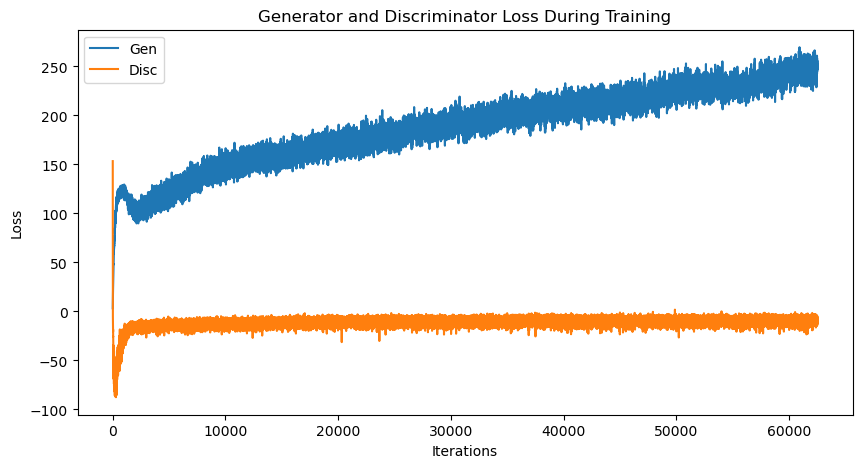

In [11]:
## :: Check if the directory 'Results/Loss_Data' exists, create if not ::
if not os.path.exists('results/Loss_Data'):
    os.makedirs('results/Loss_Data') 

## :: Save the generator and discriminator loss arrays ::
np.save('results/Loss_Data/WGANGP_GLoss', GenLoss) 
np.save('results/Loss_Data/WGANGP_DLoss', DiscLoss) 

## :: Load the saved loss arrays ::
GenLoss = np.load('results/Loss_Data/WGANGP_GLoss.npy')
DiscLoss = np.load('results/Loss_Data/WGANGP_DLoss.npy')

## :: Set up the plot for Generator and Discriminator loss during training ::
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")

## :: Plot the loss for the Generator and Discriminator ::
plt.plot(GenLoss, label="Gen")
plt.plot(DiscLoss, label="Disc")

## :: Label the axes and add a legend ::
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

## :: Save the plot as a PDF file ::
plt.savefig('results/Loss.pdf', format='pdf', dpi=100, bbox_inches='tight')

## :: Display the plot ::
plt.show()


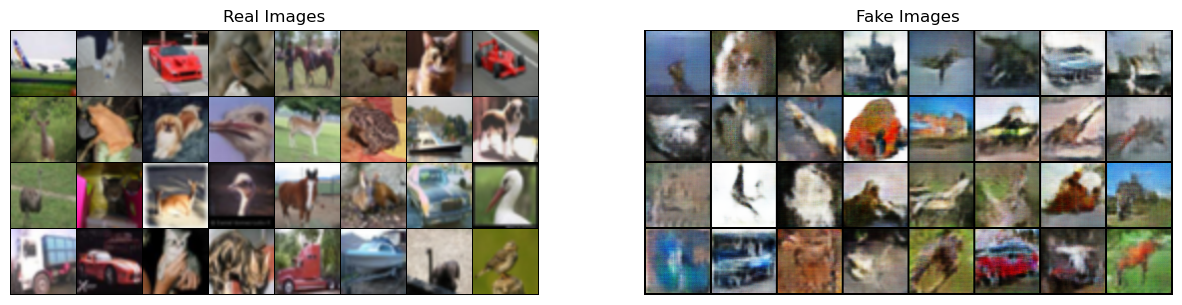

In [12]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=1, normalize=True).cpu(),(1,2,0)))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.savefig('results/WGANGP_BEST_FAKE_32.pdf',
            format='pdf',
            dpi=100,
            bbox_inches='tight')
plt.show()

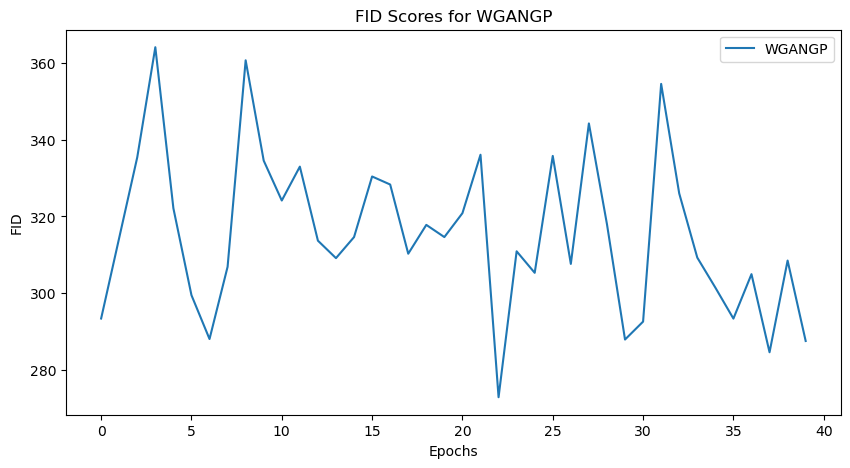

In [13]:
## :: Set up the plot for FID scores for WGANGP ::
plt.figure(figsize=(10, 5))
plt.title("FID Scores for WGANGP")

## :: Plot the FID scores for WGANGP ::
plt.plot(FID_list, label="WGANGP")

## :: Label the axes and add a legend ::
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.legend()

## :: Save the plot as a PDF file ::
plt.savefig('Results/FID.pdf', format='pdf', bbox_inches='tight')

## :: Display the plot ::
plt.show()

## :: Check if the directory 'Results/FID_score' exists, create if not ::
if not os.path.exists('Results/FID_score'):
    os.makedirs('Results/FID_score') 

## :: Save the FID scores list as a .npy file ::
np.save('Results/FID_score/WGANGP_FID', FID_list)
